### Project Title : Classification model for predicting MIS_Status using SBA Loans data
#### Name : Megha Chandrasekharan Nair
#### UTDID : mxc220113

### <span style="color: lightgreen;">This notebook deals with model training. The agenda is to train two models which will classify their MIS_Status of SBA loans records as 0 or 1. 1 being the loan gets defaulted and 0 being the loan is paid in full.It includes step by step processes of data cleaning, preprocessing, encoding categorical columns, scaling the numerical columns, model training and hypertuning.</span> ###

#### Step 1: <span style="color:yellow;font-style:italic">Import all the required libraries needed to run the model.</span>

In [1]:
import pandas.api.types as ptypes
import pandas as pd
import numpy as np
import seaborn as sns 
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder,RobustScaler
from category_encoders import WOEEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.metrics import f1_score,roc_auc_score
from sklearn.model_selection import GridSearchCV
from scipy.stats import loguniform
import pickle
import warnings
warnings.filterwarnings("ignore")
import inspect

#### Step 2: <span style="color:yellow;font-style:italic">Read data from the csv file named "SBA_loans_project_1.csv" into a variable named data_full</span>

In [2]:
data_full = pd.read_csv("./data/SBA_loans_project_1.csv")
data_full.head()

,index,City,State,Zip,Bank,BankState,NAICS,NoEmp,NewExist,CreateJob,RetainedJob,FranchiseCode,UrbanRural,RevLineCr,LowDoc,DisbursementGross,BalanceGross,GrAppv,SBA_Appv,MIS_Status
0,0,APPLETON,WI,59414,ASSOCIATED BANK NATL ASSOC,WI,321918,26,1.0,0,0,1,0,0,N,100000.0,0.0,100000.0,80000.0,0
1,1,WEATHERFORD,TX,76086,REGIONS BANK,AL,621391,2,1.0,1,3,0,1,N,N,146200.0,0.0,146200.0,124270.0,0
2,2,FLORENCE,SC,29505,"SUPERIOR FINANCIAL GROUP, LLC",CA,236220,3,1.0,3,3,0,1,N,N,20000.0,0.0,20000.0,17000.0,1
3,3,BOSTON,MA,2124,CITIZENS BANK NATL ASSOC,RI,236115,5,1.0,0,5,1,1,N,N,73100.0,0.0,75000.0,37500.0,1
4,4,LAFAYETTE,IN,47904,THE HUNTINGTON NATIONAL BANK,OH,0,82,1.0,0,0,1,0,N,Y,80000.0,0.0,80000.0,64000.0,0


##### Step 3: <span style="color:yellow;font-style:italic">Lets describe the data to observe the factors that might impact our model(like ranges of each column,identify skewness which might indicate outliers,need for scaling etc.) so that we can take effective steps to get the best model.</span>

In [3]:
data_full.describe()

,index,Zip,NAICS,NoEmp,NewExist,CreateJob,RetainedJob,FranchiseCode,UrbanRural,DisbursementGross,BalanceGross,GrAppv,SBA_Appv,MIS_Status
count,800255.000000,800255.000000,800255.000000,800255.000000,800134.000000,800255.000000,800255.000000,800255.000000,800255.000000,8.002550e+05,800255.000000,8.002550e+05,8.002550e+05,800255.000000
mean,400127.000000,53789.689389,398523.640241,11.429704,1.280583,8.452672,10.808695,2759.730583,0.757813,2.009724e+05,3.260593,1.925229e+05,1.493414e+05,0.175169
std,231013.864173,31191.480137,263292.687557,75.201079,0.451842,237.167956,237.465427,12773.618653,0.646547,2.874264e+05,1527.422092,2.829154e+05,2.279605e+05,0.380112
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000,2.000000e+02,1.000000e+02,0.000000
25%,200063.500000,27558.000000,235210.000000,2.000000,1.000000,0.000000,0.000000,1.000000,0.000000,4.200000e+04,0.000000,3.500000e+04,2.125000e+04,0.000000
50%,400127.000000,55409.000000,445310.000000,4.000000,1.000000,0.000000,1.000000,1.000000,1.000000,1.000000e+05,0.000000,9.000000e+04,6.120000e+04,0.000000
75%,600190.500000,83704.000000,561730.000000,10.000000,2.000000,1.000000,4.000000,1.000000,1.000000,2.372760e+05,0.000000,2.250000e+05,1.750000e+05,0.000000
max,800254.000000,99999.000000,928120.000000,9999.000000,2.000000,8800.000000,9500.000000,92006.000000,2.000000,1.144632e+07,996262.000000,5.472000e+06,5.472000e+06,1.000000


#### Step 3: <span style="color:yellow;font-style:italic">Following the data description in the attached kaggle link given in the project-starter file</span>
<ul style="color:orange">
    <li>We fill missing values in numerical columns to 0 and "Missing" for the categorical columns.</li>
    <li>We need to classify if a loan is for a Franchise or a non-franchise. A code greater than 1 indicates its a franchise</li>
    <li>Classifying if its a new business or an existing business.</li>
    <li>Classifying if the loan was disbursed as a revolving line of credit or not</li>
    <li>Classifying if its a Urban or a rural business</li>
    <li>Classifying if the loan was approved with low documentation</li>
    <li>We classify NAICS column based on their economic sectors. The first two digits of the NAICS code stands for the sector.</li>
</ul>

In [4]:
artifacts_dict = {}
artifacts_functions = {}# creating a dictionary which will store the intermediate outputs and functions which can be
#dumped into artifacts folder and later retreived and reused in the scoring function.

In [5]:
#Below function is to extract first two digits of NAICS which represents a sector. Few sectors have multiple two digit codes,which is handled below.
def get_naics(x):
        x = int(str(x)[:2])
        if x == 0:
            return "Missing" # No valid NAICS code interpreted as missing
        elif 31 <= x <= 33:
            return str(31) # Manufacturing sector
        elif 44 <= x <= 45:
            return str(44) # Retail trade
        elif 48 <= x <= 49:
            return str(48) #Transportation and warehousing
        else:
            return str(x) 
artifacts_functions["get_naics"] = inspect.getsource(get_naics) #storing the function into artifacts dictionary

#Below function is to fill missing values. 0 for numerical and Missing for categorical.
def fillMissingValues(inputdata):
    for col in inputdata.columns:
        if(inputdata[col].isna().sum()>0):
            if(ptypes.is_numeric_dtype(inputdata[col])):
                inputdata[col].fillna(0,inplace=True)
            else:
                inputdata[col].fillna("Missing",inplace=True)
artifacts_functions["fillMissingValues"] = inspect.getsource(fillMissingValues) #storing the function into the artifacts dict

#Below function cleans the Franchisecode,RevLineCr,NewExist,UrbanRural,LowDoc and NAICS columns
def data_clean_preprocess(inputdata):
    #franchise if a code > 1 else not a franchise
    inputdata["FranchiseCode"] = inputdata["FranchiseCode"].apply(lambda x: 0 if (x == 0 or x == 1) else 1)
    #new business if value is 0 else existing business
    inputdata["NewExist"] = inputdata["NewExist"].apply(lambda x: 0 if (x==1 or x==0) else 1)
    #Valid values are only 'Y','N' rest are considered Missing
    inputdata["RevLineCr"] = inputdata["RevLineCr"].apply(lambda x: 'Y' if (x == 'Y' or x == 1) else ('N' if (x == 'N'  or x==0) else 'Missing'))
    #Value 1 indicates 'Urban', 2 indicates 'Rural' else missing
    inputdata["UrbanRural"] = inputdata["UrbanRural"].apply(lambda x: 'Urban' if (x == 1) else ('Rural' if (x==2) else 'Missing'))
    #Valid values are only 'Y','N' rest are considered Missing
    inputdata["LowDoc"] = inputdata["LowDoc"].apply(lambda x: 'Y' if (x == 'Y' or x == 1) else ('N' if (x == 'N'  or x==0) else 'Missing'))
    #Apply sectors to NAICS column
    inputdata['NAICS'] = inputdata['NAICS'].apply(get_naics)
    #Set category types to the columns. ZIP is considered category as the numbers as such doesnt hold any value.
    inputdata[['Zip',"NewExist","FranchiseCode",
               "UrbanRural","RevLineCr","NAICS","LowDoc"]] = inputdata[['Zip',"NewExist","FranchiseCode","UrbanRural"
                                                                        ,"RevLineCr","NAICS","LowDoc"]].astype('category')
    #fill missing values
    fillMissingValues(inputdata)
    
artifacts_functions["data_clean_preprocess"] = inspect.getsource(data_clean_preprocess) # store the function in the dictionary

In [6]:
#We will apply the cleaning function into the data
data_clean_preprocess(data_full)

#### Step 4: <span style="color:yellow;font-style:italic">Lets generate a heatmap to understand the correlations between the numerical columns. It helps in understanding which columns are highly correlated,need to be removed,need interaction features etc.</span>
As per the heatmap generated, we observe that CreateJob and RetainedJob are highly correlated,same with the DisbursementGross,SBA_Appv and Gr_Appv. It is ideal to have interaction features between them and if possible remove them after the interaction features are created to boost the model performance.

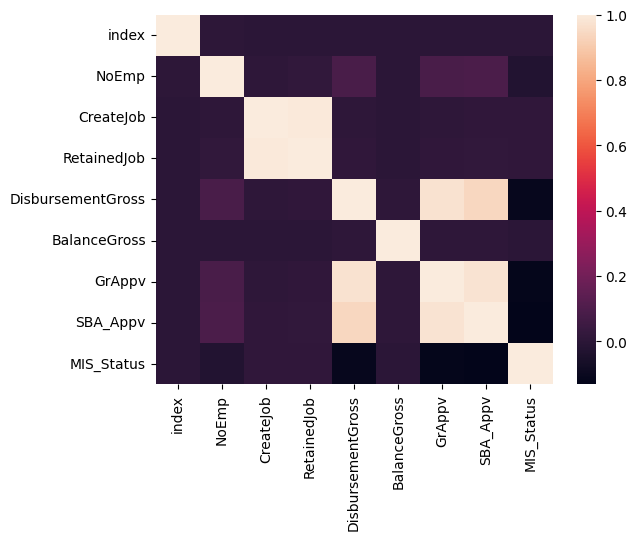

In [7]:
numeric_columns = data_full.select_dtypes(include=['number']).columns.tolist()
sns.heatmap(data_full[numeric_columns].corr());

#### Step 5: <span style="color:yellow;font-style:italic">Let us define the target column and split the data into training,test and validation datasets</span>

In [8]:
X = data_full
Y = data_full['MIS_Status'] #MIS_Status is the target column
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=42)

#### Step 6: <span style="color:yellow;font-style:italic">Create engineered features</span>
<ol style="color:orange">
    <li>Bank Loan Count: Number of loans that are given by a bank.High number might indicate that bank's experience in dealing with deafults.</li>
    <li>Bank UR: The mean guaranteed approval of each bank as per the urban rural status. Can track changes in approvals for urban and rural areas.</li>
    <li>Franchise GrAppv: The mean SBA and disbursement difference for franchise and non franchise</li>
    <li>UrbanRuralGross:  The mean SBA and disbursement difference for Urban and Rural</li>
    <li>NewExistGross:  The mean SBA and disbursement difference for Existing and new businesses.</li>
    <li>RevLineCrGross:  The mean SBA and disbursement difference for Revolving Line of Credit</li>
    <li>LowDocGross:  The mean SBA and disbursement differencefor LowDocumentation</li>
    <li>State default rates: The mean default rates per state</li>
    <li>Industry default rates: The mean defaults per industry</li>
    <li>DisSbaDiff: If Disbursement is greater than the SBA_Appv coverage amount.</li>
    <li>LoanToEmployeeRatio: Loan approved to the number of employees in the business.Might indicate the size of the business.</li>
    <li>Bank_BankState: To check performance of banks in their state vs others</li>
    <li>SBA_Risk: The percentage of approved amount covered by SBA </li>
    <li>ProportionSBA: Proportion of SBA Coverage</li>
    <li>DisGrossDiff: If Disbursement is greater than the GrAppv coverage amount.</li>
    <li>CreateRetain : Ratio of jobs created to retained.</li>
    <li>City_State: Equivalent to interaction term City*State.Indicating performance of a city within state.</li>
    <li>CreateNoEmp: Ratio of number of jobs created to the size of the firm.</li>
    <li>Interaction features: Total of 6 Interaction features are created between categorical variables RevLineCr,LowDoc,UrbanRural and NewExist</li>
</ol>

In [9]:
#The below values are taken only from the training data and hence has to stored in the artifacts dictionary
#as they have to be resused for mapping in the scoring
artifacts_dict['bank_loan_counts'] = X_train['Bank'].value_counts().to_dict()
X_train["DisSbaDiff"] = (X_train["DisbursementGross"] > X_train["SBA_Appv"]).astype(int)
artifacts_dict['bankperformance_ur'] = X_train.groupby(['Bank','UrbanRural'])['DisSbaDiff'].mean().to_dict()
artifacts_dict['franchise_GrAppv'] = X_train.groupby('FranchiseCode')['DisSbaDiff'].mean().to_dict()
artifacts_dict['urbanRuralGross'] = X_train.groupby('UrbanRural')['DisSbaDiff'].mean().to_dict()
artifacts_dict['NewExistGross'] = X_train.groupby('NewExist')['DisSbaDiff'].mean().to_dict()
artifacts_dict['RevLineCrGross'] = X_train.groupby('RevLineCr')['DisSbaDiff'].mean().to_dict()
artifacts_dict['LowDocGross'] = X_train.groupby('LowDoc')['DisSbaDiff'].mean().to_dict()
X_train["Bank_UR"] = X_train.apply(lambda row: artifacts_dict["bankperformance_ur"].get((row['Bank'], row['UrbanRural']), 0), axis=1)
artifacts_dict['BankURMean'] = X_train["Bank_UR"].mean()
artifacts_dict['state_default_rates'] = X_train.groupby('State')['MIS_Status'].apply(lambda x: (x == 1).mean()).to_dict()
artifacts_dict['industry_default_rates'] = X_train.groupby('NAICS')['MIS_Status'].apply(lambda x: (x == 1).mean()).to_dict()

#a function that will create all the above listed interaction features for any input dataframe.
def create_engineered_features(inputdata,artifacts_dict):
    inputdata["DisSbaDiff"] = (inputdata["DisbursementGross"] > inputdata["SBA_Appv"]).astype(int)
    inputdata["Bank_UR"] = inputdata.apply(lambda row: artifacts_dict["bankperformance_ur"].get((row['Bank'], row['UrbanRural']), 0), axis=1)
    inputdata["Bank_UR"].fillna(artifacts_dict["BankURMean"],inplace=True)
    inputdata['StateDefaultRate'] = inputdata['State'].map(artifacts_dict["state_default_rates"])
    inputdata['IndustryDefaultRate'] = inputdata['NAICS'].map(artifacts_dict["industry_default_rates"])
    inputdata['LoanToEmployeeRatio'] = inputdata['GrAppv'] / (inputdata['NoEmp']+1)
    inputdata['BankLoanCount'] = inputdata['Bank'].map(artifacts_dict["bank_loan_counts"]).fillna(0)
    inputdata["Bank_BankState"] = (inputdata["Bank"]==inputdata["BankState"]).astype(int)
    inputdata["SBA_Risk"] = inputdata["SBA_Appv"] / (inputdata["GrAppv"]+1)
    inputdata['franchise_GrAppv'] = inputdata['FranchiseCode'].apply(lambda x:artifacts_dict["franchise_GrAppv"][x])
    inputdata['urbanRuralGross'] = inputdata['UrbanRural'].apply(lambda x:artifacts_dict["urbanRuralGross"][x])
    inputdata['NewExistGross'] = inputdata['NewExist'].map(artifacts_dict["NewExistGross"])
    inputdata['RevLineCrGross'] = inputdata['RevLineCr'].apply(lambda x:artifacts_dict["RevLineCrGross"][x])
    inputdata['LowDocGross'] = inputdata['LowDoc'].apply(lambda x:artifacts_dict["LowDocGross"][x])
    inputdata["ProportionSBA"] = (inputdata["GrAppv"] - inputdata["SBA_Appv"])/(inputdata["GrAppv"]+1)
    inputdata["DisGrossDiff"] = (inputdata["DisbursementGross"] > inputdata["GrAppv"]).astype(int)
    inputdata["CreateRetain"] = inputdata["CreateJob"]/(inputdata["RetainedJob"]+1)
    inputdata["City_State"] = inputdata["City"]+"_"+inputdata["State"]
    inputdata["CreateNoEmp"] = inputdata["CreateJob"]/(inputdata["NoEmp"]+1)
    inputdata["NewExist_RevLineCr"] = inputdata["NewExist"].astype(str)+"_"+inputdata["RevLineCr"].astype(str)
    inputdata["UrbanRural_RevLineCr"] = inputdata["UrbanRural"].astype(str)+"_"+inputdata["RevLineCr"].astype(str)
    inputdata["LowDoc_RevLineCr"] = inputdata["LowDoc"].astype(str)+"_"+inputdata["RevLineCr"].astype(str)
    inputdata["LowDoc_NewExist"] = inputdata["LowDoc"].astype(str)+"_"+inputdata["NewExist"].astype(str)
    inputdata["UrbanRural_LowDoc"] = inputdata["UrbanRural"].astype(str)+"_"+inputdata["LowDoc"].astype(str)
    inputdata["UrbanRural_NewExist"] = inputdata["UrbanRural"].astype(str)+"_"+inputdata["NewExist"].astype(str)
    #mapping mean values based on categorical columns creates the new column as a categorical datatype.Hence converting to numeric.
    inputdata['franchise_GrAppv'] = pd.to_numeric(inputdata['franchise_GrAppv'], errors='coerce')
    inputdata['NewExistGross'] = pd.to_numeric(inputdata['NewExistGross'],errors='coerce')
    inputdata['LowDocGross'] = pd.to_numeric(inputdata['LowDocGross'],errors='coerce')
    inputdata['RevLineCrGross'] = pd.to_numeric(inputdata['RevLineCrGross'],errors='coerce')
    inputdata['urbanRuralGross'] = pd.to_numeric(inputdata['urbanRuralGross'],errors='coerce')
    inputdata['IndustryDefaultRate'] = pd.to_numeric(inputdata['IndustryDefaultRate'],errors='coerce')
    inputdata['Bank_UR'] = pd.to_numeric(inputdata['Bank_UR'],errors='coerce')
    #Once features are created,filling missing values.
    fillMissingValues(inputdata)
artifacts_functions["create_engineered_features"] = inspect.getsource(create_engineered_features) #store the function into the dictionary

In [10]:
#pass all the dataframes for creating the required engineered features
create_engineered_features(X_train,artifacts_dict)
create_engineered_features(X_val,artifacts_dict)
create_engineered_features(X_test,artifacts_dict)

#### Step 7: <span style="color:yellow"> We will use the same set of features for the H2O model, so lets load the cleaned and preprocessed data into h2oframe before we move ahead with Scikit encoding and scaling</span>

In [11]:
#H2O initialization
import h2o
h2o.init(max_mem_size = "8G",nthreads=8)            
h2o.remove_all()  
#loading data into h2oframes
h2o_train = h2o.H2OFrame(X_train)
h2o_val = h2o.H2OFrame(X_val)
h2o_test = h2o.H2OFrame(X_test)

Checking whether there is an H2O instance running at http://localhost:54321. connected.


H2O_cluster_uptime:,1 hour 29 mins
H2O_cluster_timezone:,America/Chicago
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.46.0.2
H2O_cluster_version_age:,1 month and 22 days
H2O_cluster_name:,H2O_from_python_megha_1safhc
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,7.915 Gb
H2O_cluster_total_cores:,8
H2O_cluster_allowed_cores:,8
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%


#### Step 8: <span style="color:yellow">This step encodes all categorical columns into numerical using onehot encoding and WOE encoder. The columns with less than 11 values use one hot encoding and others use WOE. The encoders are fit in the training data and any other data is transformed separately based on the fit. The fitted encoders are save in the artifacts for reusability. I have used WOE instead of target as WOE is best suited for logistic regression-binary classification problems, especially in credit scoring and risk modeling.</span>

In [12]:
artifacts_dict["categorical_encoders"] = {}
artifacts_dict["CategoricalColumns"] = []
artifacts_dict["numColumns"] = []
for col in X_train.columns:
    if(ptypes.is_numeric_dtype(X_train[col])):
        continue; # if a column is numeric skip
    elif(X_train[col].nunique() <=10): # if number of unique values are less than or equal to 10, do one hot encoding
        artifacts_dict["CategoricalColumns"].append(col)
        oh_encoder = OneHotEncoder(handle_unknown='ignore',sparse_output = False)
        artifacts_dict["categorical_encoders"][col] = oh_encoder
        one_hot_encoded =  artifacts_dict["categorical_encoders"][col].fit_transform(X_train[[col]]) # fit transform training data
        one_hot_encoded_df = pd.DataFrame(one_hot_encoded, columns= artifacts_dict["categorical_encoders"][col]
                                          .get_feature_names_out([col]),index=X_train.index)
        X_train = X_train.join(one_hot_encoded_df)
        X_train=X_train.drop(columns=[col]) # drop the encoded column
        
        one_hot_encoded_val =  artifacts_dict["categorical_encoders"][col].transform(X_val[[col]]) #transform validation data
        one_hot_encoded_df_val = pd.DataFrame(one_hot_encoded_val, columns= artifacts_dict["categorical_encoders"][col]
                                              .get_feature_names_out([col]),index=X_val.index)
        X_val = X_val.join(one_hot_encoded_df_val)
        X_val=X_val.drop(columns=[col])# drop the encoded column

        one_hot_encoded_test =  artifacts_dict["categorical_encoders"][col].transform(X_test[[col]]) #transform test data
        one_hot_encoded_df_test = pd.DataFrame(one_hot_encoded_test, columns= artifacts_dict["categorical_encoders"][col].get_feature_names_out([col]),index=X_test.index)
        X_test = X_test.join(one_hot_encoded_df_test)
        X_test = X_test.drop(columns=[col])# drop the encoded column
    else: # else use WOE
        artifacts_dict["CategoricalColumns"].append(col)
        woe_encoder = WOEEncoder(cols=[col])
        artifacts_dict["categorical_encoders"][col] = woe_encoder.fit(X_train[col], y_train) #fit targetencoder to training data & storing it to python dict
        X_train[col+"_woe"]= artifacts_dict["categorical_encoders"][col].transform(X_train[col]) #train data transforming
        X_train = X_train.drop(columns=[col])
    
        X_val[col+"_woe"]= artifacts_dict["categorical_encoders"][col].transform(X_val[col]) #val data transforming
        X_val = X_val.drop(columns=[col])

        X_test[col+"_woe"]= artifacts_dict["categorical_encoders"][col].transform(X_test[col]) #test data transforming
        X_test = X_test.drop(columns=[col])


#### Step 8: <span style="color:yellow">This step involves scaling the numerical columns of our dataset. Upon examining the data, we observed that the columns are in different ranges, with some being highly skewed and likely containing outliers. To address these issues, it is ideal to standardize the data to reduce skewness and minimize the negative impact of outliers.For this purpose, I used the RobustScaler, which is particularly effective when dealing with data that contains outliers.</span>

In [13]:
artifacts_dict["numColumns"] = X_train.select_dtypes(include=['number']).columns.tolist()
scaler = RobustScaler()
artifacts_dict["Scaler"] = scaler.fit(X_train[artifacts_dict["numColumns"]]) #fitting the sacler into training data and storing it in artifactsdict
X_trainScaled = artifacts_dict["Scaler"].transform(X_train[artifacts_dict["numColumns"]]) # transforming training data
X_valScaled = artifacts_dict["Scaler"].transform(X_val[artifacts_dict["numColumns"]])# transforming validation data
X_testScaled = artifacts_dict["Scaler"].transform(X_test[artifacts_dict["numColumns"]])# transforming test data
# replacing actual columns with scaled columns
X_train[artifacts_dict["numColumns"]] = X_trainScaled 
X_val[artifacts_dict["numColumns"]] = X_valScaled
X_test[artifacts_dict["numColumns"]] = X_testScaled

#### Step 9: <span style="color:yellow">Data preview and dropping unwanted columns. I have removed index,target column(MIS_Status) and one of the one hot encoded columns of each category to avoid multicollinearity. The base case is 'NewExist_1','FranchiseCode_1','UrbanRural_Rural','RevLineCr_N','LowDoc_N'</span>

In [14]:
X_train = X_train.drop(columns = ['index','NewExist_1','FranchiseCode_1','UrbanRural_Rural','RevLineCr_N','LowDoc_N',"MIS_Status"])
X_val = X_val.drop(columns = ['index','NewExist_1','FranchiseCode_1','UrbanRural_Rural','RevLineCr_N','LowDoc_N',"MIS_Status"])
X_test = X_test.drop(columns = ['index','NewExist_1','FranchiseCode_1','UrbanRural_Rural','RevLineCr_N','LowDoc_N',"MIS_Status"])
# Set display option to show all columns
pd.set_option('display.max_columns', None)
X_train.head()

,NoEmp,CreateJob,RetainedJob,DisbursementGross,BalanceGross,GrAppv,SBA_Appv,DisSbaDiff,Bank_UR,StateDefaultRate,IndustryDefaultRate,LoanToEmployeeRatio,BankLoanCount,Bank_BankState,SBA_Risk,franchise_GrAppv,urbanRuralGross,NewExistGross,RevLineCrGross,LowDocGross,ProportionSBA,DisGrossDiff,CreateRetain,CreateNoEmp,City_woe,State_woe,Zip_woe,Bank_woe,BankState_woe,NAICS_woe,NewExist_0,FranchiseCode_0,UrbanRural_Missing,UrbanRural_Urban,RevLineCr_Missing,RevLineCr_Y,LowDoc_Missing,LowDoc_Y,City_State_woe,NewExist_RevLineCr_0_Missing,NewExist_RevLineCr_0_N,NewExist_RevLineCr_0_Y,NewExist_RevLineCr_1_Missing,NewExist_RevLineCr_1_N,NewExist_RevLineCr_1_Y,UrbanRural_RevLineCr_Missing_Missing,UrbanRural_RevLineCr_Missing_N,UrbanRural_RevLineCr_Missing_Y,UrbanRural_RevLineCr_Rural_Missing,UrbanRural_RevLineCr_Rural_N,UrbanRural_RevLineCr_Rural_Y,UrbanRural_RevLineCr_Urban_Missing,UrbanRural_RevLineCr_Urban_N,UrbanRural_RevLineCr_Urban_Y,LowDoc_RevLineCr_Missing_Missing,LowDoc_RevLineCr_Missing_N,LowDoc_RevLineCr_Missing_Y,LowDoc_RevLineCr_N_Missing,LowDoc_RevLineCr_N_N,LowDoc_RevLineCr_N_Y,LowDoc_RevLineCr_Y_Missing,LowDoc_RevLineCr_Y_N,LowDoc_RevLineCr_Y_Y,LowDoc_NewExist_Missing_0,LowDoc_NewExist_Missing_1,LowDoc_NewExist_N_0,LowDoc_NewExist_N_1,LowDoc_NewExist_Y_0,LowDoc_NewExist_Y_1,UrbanRural_LowDoc_Missing_Missing,UrbanRural_LowDoc_Missing_N,UrbanRural_LowDoc_Missing_Y,UrbanRural_LowDoc_Rural_Missing,UrbanRural_LowDoc_Rural_N,UrbanRural_LowDoc_Rural_Y,UrbanRural_LowDoc_Urban_Missing,UrbanRural_LowDoc_Urban_N,UrbanRural_LowDoc_Urban_Y,UrbanRural_NewExist_Missing_0,UrbanRural_NewExist_Missing_1,UrbanRural_NewExist_Rural_0,UrbanRural_NewExist_Rural_1,UrbanRural_NewExist_Urban_0,UrbanRural_NewExist_Urban_1
156364,-0.375,10.0,-0.25,-0.438144,0.0,-0.394737,-0.316278,0.0,0.622120,1.072650,0.252152,-0.245614,0.474272,0.0,0.285561,0.0,0.00000,0.0,-1.0,0.0,-2.857552e-01,0.0,42.5,23.333333,0.954802,0.918167,0.992721,1.676438,0.450159,0.199419,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.830898,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
738650,-0.125,0.0,0.50,-0.385052,0.0,-0.340526,-0.316931,0.0,-0.128091,-1.613098,0.304680,-0.295088,0.067707,0.0,-0.714341,0.0,-0.49325,1.0,-1.0,0.0,7.142698e-01,0.0,0.0,0.000000,0.016877,-1.910907,0.558551,-0.310987,0.728026,0.238474,-1.0,0.0,0.0,-1.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,-1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
268548,1.750,0.0,-0.25,-0.051546,0.0,0.000000,0.070661,0.0,-0.894950,0.071552,0.095815,-0.361958,-0.185465,0.0,0.142839,0.0,-1.00000,0.0,-1.0,0.0,-1.428682e-01,0.0,0.0,0.000000,1.114378,0.067270,3.681698,-0.404491,-0.323878,0.078748,0.0,0.0,1.0,-1.0,0.0,0.0,0.0,0.0,1.024355,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
313434,-0.250,0.0,0.25,0.515464,0.0,0.578947,0.580049,0.0,-0.916361,0.000000,0.252152,2.245614,-0.170995,0.0,-0.000005,0.0,0.00000,0.0,0.0,0.0,-7.703420e-07,0.0,0.0,0.000000,-0.696605,0.000000,-0.471812,-0.953672,0.450159,0.199419,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,-0.628670,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
350466,0.000,0.0,-0.25,-0.322165,0.0,-0.276316,-0.188193,0.0,-0.220674,0.071552,-0.901708,-0.245614,1.646725,0.0,0.322838,0.0,-1.00000,0.0,-1.0,0.0,-3.229199e-01,0.0,0.0,0.000000,-0.172927,0.067270,-0.223583,-0.062246,0.097722,-1.043003,0.0,0.0,1.0,-1.0,0.0,0.0,0.0,0.0,-0.167242,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,

#### Step 9 : <span style="color:yellow"> With the above data a logistic regression model is trained using the training data. The trained model is then used to predict the validation set to understand its performance and necessary steps needed to hypertune further.</span>

In [15]:
basemodel = LogisticRegression(
    max_iter=2000,
    class_weight='balanced'
)
basemodel.fit(X_train, y_train)
y_pred = basemodel.predict(X_train)
y_pred_val = basemodel.predict(X_val)
print("_________________Training_______________")
print(classification_report(y_train, y_pred))
print("_________________Validation_______________")
print(classification_report(y_val, y_pred_val))
y_pred_prob = basemodel.predict_proba(X_train)[:, 1]
y_pred_prob2 = basemodel.predict_proba(X_val)[:, 1]
roc_auc_train = roc_auc_score(y_train, y_pred_prob)
print("AUC of training data is {}".format(roc_auc_train))
roc_auc_val = roc_auc_score(y_val, y_pred_prob2)
print("AUC of validation data is {}".format(roc_auc_val))

_________________Training_______________
              precision    recall  f1-score   support

           0       0.93      0.72      0.81    395952
           1       0.36      0.74      0.49     84201

    accuracy                           0.72    480153
   macro avg       0.65      0.73      0.65    480153
weighted avg       0.83      0.72      0.75    480153

_________________Validation_______________
              precision    recall  f1-score   support

           0       0.91      0.71      0.80    132006
           1       0.33      0.69      0.45     28045

    accuracy                           0.70    160051
   macro avg       0.62      0.70      0.62    160051
weighted avg       0.81      0.70      0.74    160051

AUC of training data is 0.8106527342462421
AUC of validation data is 0.7674360386818185


Summary of the above results.
The model struggles more with predicting class 1 (minority class), as indicated by lower precision and varying levels of recall.
Both in training and validation sets, there is a significant class imbalance (0 being much more frequent than 1), which affects the precision and recall for class 1.
The slight drop in metrics from training to validation suggests some degree of overfitting, where the model may be fitting too closely to the training data characteristics.
Higher range of AUC,indicates that the model has good discrimination ability between the classes.

#### Step 10: <span style="color:yellow">Model Hypertuning. These are the list of parameters that are used for model tuning.</span>
<ul style="color:orange">
    <li>Regularization strength 5 values logarithmically spaced between 10^-4 to 10^4</li>
    <li>Types of regularizations: Lasso and ridge</li>
    <li>Optimization algorithms:liblinear as it supports both l1 and l2 regularizations</li>
    <li>Tolerance for Convergence:[1e-4, 1e-3, 1e-2]</li>
    <li>Handling Class Imbalance:With None and balanced class_weight parameter</li>
</ul>

In [16]:
param_grid = {
    'C': np.logspace(-4, 4, 5),  # 5 different values for regularization strength
    'penalty': ['l1', 'l2'],  # Use only 'l1' and 'l2' penalties
    'solver': ['liblinear'],  # Solver that support both 'l1' and 'l2' penalties
    'max_iter': [3000],
    'tol': [1e-4, 1e-3, 1e-2],  #Tolerance values
    'class_weight': [None, 'balanced']  # Class weight
}

from itertools import product
# Generate all combinations of parameters
param_combinations = list(product(
    param_grid['C'],
    param_grid['penalty'],
    param_grid['solver'],
    param_grid['max_iter'],
    param_grid['tol'],
    param_grid['class_weight']
))
# Initialize variables to store the best parameters and best score
best_params = None
best_score = 0

for params in param_combinations:
    C, penalty, solver, max_iter, tol, class_weight = params
    
    # Instantiate the logistic regression model with the current parameters
    model = LogisticRegression(
        C=C,
        penalty=penalty,
        solver=solver,
        max_iter=max_iter,
        tol=tol,
        class_weight=class_weight
    )
    
    # Fit the model on the training data
    model.fit(X_train, y_train)
    
    # Predict probabilities on the validation set
    y_val_pred_proba = model.predict_proba(X_val)[:, 1]
    
    # Calculate the ROC AUC score
    score = roc_auc_score(y_val, y_val_pred_proba)
    
    # Update best score and parameters if the current score is better
    if score > best_score:
        best_score = score
        best_params = {
            'C': C,
            'penalty': penalty,
            'solver': solver,
            'max_iter': max_iter,
            'tol': tol,
            'class_weight': class_weight
        }

# Output the best parameters and score
print(f"Best parameters found: {best_params}")
print(f"Best score achieved: {best_score}")

Best parameters found: {'C': 10000.0, 'penalty': 'l2', 'solver': 'liblinear', 'max_iter': 3000, 'tol': 0.001, 'class_weight': None}
Best score achieved: 0.7680600509557761


<ul>
    <li>Regularization Strength (C=10000.0):Indicates minimal regularization, allowing the model to fit the training data more closely.</li>
    <li>l2 penalty:Ridge regularization was chosen, which helps to prevent overfitting by penalizing large coefficients but does not force coefficients         to zero.</li>
    <li>Solver (liblinear): Efficient for small to medium-sized datasets and supports the chosen l2 penalty.</li>
    <li>Iterations (max_iter=3000): Provides ample iterations for the model to converge to a solution.</li>
    <li>Tolerance (tol=0.001): Specifies a relatively small threshold for convergence, ensuring precise optimization.</li>
    <li>Class Weight: No adjustment for class imbalance was necessary, implying the dataset may have been balanced or the model performed well without weighting.</li>
</ul>

#### Step 11: <span style="color:yellow">Training a new model with the best parameters on the training data</span>

In [17]:
bestmodel = LogisticRegression(
    class_weight=None,
    max_iter=3000,
    penalty='l2',
    tol=0.001,
    C=10000.0,
    solver='liblinear'
)# Increase max_iter if needed
bestmodel.fit(X_train, y_train)
y_pred_prob = bestmodel.predict_proba(X_train)[:, 1]
y_pred_prob2 = bestmodel.predict_proba(X_val)[:, 1]
roc_auc_train = roc_auc_score(y_train, y_pred_prob)
print("AUC of training data is {}".format(roc_auc_train))
roc_auc_val = roc_auc_score(y_val, y_pred_prob2)
print("AUC of validation data is {}".format(roc_auc_val))

AUC of training data is 0.810640120985262
AUC of validation data is 0.7680600509557761


We see a very slight increase in the AUC of validation after using a model with the best parameters. But The drop in AUC from training data to validation might be a sign of the model overfitting closely to the training data.

#### Step 12: <span style="color:yellow">Finding threshold that maximizes f1 score</span>

In [18]:
# Define a range of thresholds to evaluate
thresholds = np.arange(0.0, 1.0, 0.01)
y_probs = bestmodel.predict_proba(X_train)
# Initialize variables to store the best threshold and the highest F1 score
best_threshold_scikit = 0.0
best_f1 = 0.0
# Loop over the thresholds and calculate F1 scores
for threshold in thresholds:
    y_score = (y_probs[:, 1] >= threshold).astype(int)
    current_f1 = f1_score(y_train, y_score,average='macro')
    if current_f1 > best_f1:
        best_f1 = current_f1
        best_threshold_scikit = threshold
print(f'Best threshold: {best_threshold_scikit}')
print(f'Best F1 score: {best_f1}')

Best threshold: 0.31
Best F1 score: 0.694536735865593


#### Step 11: <span style="color:yellow">Lets train a H2O model with the data that we had stored in Step 7. Set all the categorical columns as asfactor so that the H2O GLM handles categories by its own.</span>

In [19]:
h2o_train[artifacts_dict["CategoricalColumns"]]= h2o_train[artifacts_dict["CategoricalColumns"]].asfactor()
h2o_val[artifacts_dict["CategoricalColumns"]] = h2o_val[artifacts_dict["CategoricalColumns"]].asfactor()
h2o_test[artifacts_dict["CategoricalColumns"]] = h2o_test[artifacts_dict["CategoricalColumns"]].asfactor()

#### Step 12: <span style="color:yellow">Store the model predictor columns and the target column 'MIS_Status'</span>

In [20]:
# Prepare predictors and response columns
covtype_X = h2o_train.columns
covtype_y = "MIS_Status" #Target columns
covtype_X.remove(covtype_y) #Remove target column
covtype_X.remove('index') #Remove index column

#### Step 13: <span style="color:yellow">Train a basic H2O GLM with default parameters</span>

In [21]:
from h2o.estimators.glm import H2OGeneralizedLinearEstimator
glm_binom = H2OGeneralizedLinearEstimator(
                    model_id="glm_v3",
                    solver="L_BFGS",
                    family="binomial", # classifier with binary target
                    max_iterations = 2000,
)

glm_binom.train(x=covtype_X, y=covtype_y, training_frame=h2o_train, validation_frame=h2o_val);

glm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%


In [22]:
glm_binom.model_performance(h2o_val)

ModelMetricsBinomialGLM: glm
** Reported on test data. **

MSE: 0.12413049522770588
RMSE: 0.3523215792819195
LogLoss: 0.39754376074662856
AUC: 0.7609598349213056
AUCPR: 0.4307181079129981
Gini: 0.5219196698426112
Null degrees of freedom: 160050
Residual degrees of freedom: 65807
Null deviance: 148551.6010573488
Residual deviance: 127254.55290251729
AIC: 315742.55290251726

Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.25960656340740557
       0       1      Error    Rate
-----  ------  -----  -------  ------------------
0      107854  24152  0.183    (24152.0/132006.0)
1      12732   15313  0.454    (12732.0/28045.0)
Total  120586  39465  0.2305   (36884.0/160051.0)

Maximum Metrics: Maximum metrics at their respective thresholds
metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.259607     0.453651  181
max f2                       0.14161      0.58333   276
max f0point5                 0.335576     0.448452  131
max accuracy                 0.44004      0.834428  76
max precision                0.956344     1         0
max recall                   0.00590915   1         396
max specificity              0.956344     1         0
max absolute_mcc             0.29051      0.320907  160
max min_per_class_accuracy   0.198667     0.691389  228
max mean_per_class_accuracy  0.209635     0.692187  219
max tns                      0.956344     132006    0
max fns                      0.956344     28042     0
max fps                      0.00277683   132006    399
max tps                      0.00590915   28045     396
max tnr                      0.956344     1         0
max fnr                      0.956344     0.999893  0
max fpr                      0.00277683   1         399
max tpr                      0.00590915   1         396

Gains/Lift Table: Avg response rate: 17.52 %, avg score: 17.63 %
group    cumulative_data_fraction    lower_threshold    lift       cumulative_lift    response_rate    score      cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain    kolmogorov_smirnov
-------  --------------------------  -----------------  ---------  -----------------  ---------------  ---------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------  --------------------
1        0.0100031                   0.533798           4.43437    4.43437            0.777014         0.594114   0.777014                    0.594114            0.0443573       0.0443573                  343.437   343.437            0.0416529
2        0.0200061                   0.483153           3.51827    3.97632            0.61649          0.505636   0.696752                    0.549875            0.0351934       0.0795507                  251.827   297.632            0.072195
3        0.0300029                   0.453519           3.20658    3.71985            0.561875         0.467196   0.651812                    0.522327            0.0320556       0.111606                   220.658   271.985            0.0989403
4        0.040006                    0.430118           2.98714    3.53664            0.523423         0.441395   0.61971                     0.50209             0.0298805       0.141487                   198.714   253.664            0.123041
5        0.0500028                   0.413368           2.67156    3.36369            0.468125         0.421313   0.589404                    0.485941            0.0267071       0.168194                   167.156   236.369            0.143301
6        0.100006                    0.358548           2.44664    2.90517            0.428714         0.383483   0.509059                    0.434712            0.122339        0.290533                   144.664   190.517            0.231005
7        0.150002                    0.318983           2.09036    2.63359            0.366283         0.338

From the confusion matrix, we can see that the model is struggling to correctly classify the Class 1 instances. It may be due to the class imbalances in the data or not enough features that are significant enough for the model.

#### Step 14: <span style="color:yellow">Hyper tune the GLM with hyper parameters and find the best parameters.</span>

In [23]:
from h2o.grid.grid_search import H2OGridSearch
glm_model = H2OGeneralizedLinearEstimator(
    model_id="glm_hypertune",
    solver="L_BFGS",
    family="binomial",
    max_iterations=2000,
)
# Define the hyperparameters
hyper_params = {
    'alpha': [0, 0.1, 0.25, 0.5, 0.75],   # 5 values
    'lambda': [1e-4, 5e-4, 1e-3, 5e-3, 1e-2, 5e-2, 0.1, 0.5, 1, 5]   # 10 values
}

# Perform grid search
grid = H2OGridSearch(
    model=glm_model,
    hyper_params=hyper_params,
    search_criteria={'strategy': 'Cartesian'}  # Ensure all combinations are used
)

# Train grid search
grid.train(
    x=covtype_X, y=covtype_y, training_frame=h2o_train,validation_frame=h2o_val
)
# Get the grid search results
grid_results = grid.get_grid(
    sort_by='auc', 
    decreasing=True
)

# Print the grid search results
print(grid_results[0])

glm Grid Build progress: |███████████████████████████████████████████████████████| (done) 100%
Model Details
H2OGeneralizedLinearEstimator : Generalized Linear Modeling
Model Key: Grid_GLM_py_1_sid_ad88_model_python_1720240142070_4_model_1


GLM Model: summary
    family    link    regularization             number_of_predictors_total    number_of_active_predictors    number_of_iterations    training_frame
--  --------  ------  -------------------------  ----------------------------  -----------------------------  ----------------------  ----------------
    binomial  logit   Ridge ( lambda = 1.0E-4 )  94244                         94243                          68                      py_1_sid_ad88

ModelMetricsBinomialGLM: glm
** Reported on train data. **

MSE: 0.1172288020623717
RMSE: 0.3423869186496057
LogLoss: 0.37638208822494584
AUC: 0.7921747277919343
AUCPR: 0.48332582245019046
Gini: 0.5843494555838686
Null degrees of freedom: 480152
Residual degrees of freedom: 385909
Null dev

#### Step 15: <span style="color:yellow">Lets store the best model found into a variable so that we can test its performance on the test data.</span>

From the grid search we can get the best parameters alpha and lambda. But since the best model was already trained on the training dataframe.We can use the same model for further steps.

In [24]:
best_model_h2o = grid_results.models[0]

#### Step 16: <span style="color:yellow">Use test data to evaluate AUC using both scikit and H2O model. Choose the model that gives the best AUC score as the best model</span>

In [25]:
perf_h2o = best_model_h2o.model_performance(h2o_test).auc()
perf_h2o

0.7839297878334643

In [26]:
y_pred_probtest = bestmodel.predict_proba(X_test)[:, 1]
roc_auc_test = roc_auc_score(y_test, y_pred_probtest)
roc_auc_test

0.767999098779764

#### Step 17: <span style="color:yellow">Since we found that H2O GLM gives a better AUC compared to Scikit Log regression on the test data. We extract the threshold that maximizes the F1 score from the model and store it into artifacts.</span>

In [27]:
# Extract F1 scores at different thresholds
max_f1_threshold = best_model_h2o.model_performance(h2o_train).find_threshold_by_max_metric('f1')
max_f1_threshold

0.24808936670883533

In [28]:
artifacts_dict["threshold"] = max_f1_threshold

#### Step 18: <span style="color:yellow">Save the H2O model into the artifacts folder and dump the artifacts dictionary and functions into the artifacts folder using pickle.</span>

In [29]:
artifacts_dict["ModelPath"] = 'artifacts/'+best_model_h2o.model_id

In [30]:
h2o.save_model(model=best_model_h2o,path="../artifacts",force=True)
artifacts_functions_file = open("../artifacts/artifacts_functions_file.pkl", "wb")
pickle.dump(obj=artifacts_functions, file=artifacts_functions_file)
artifacts_functions_file.close()
artifacts_dict_file = open("../artifacts/artifacts_dict_file.pkl", "wb")
pickle.dump(obj=artifacts_dict, file=artifacts_dict_file)
artifacts_dict_file.close()

### Conclusion and Findings on Logistic Regression and H2O GLM Models

## Overview
De developed two predictive models predictast the outcome of SBA loans based on several featureFirst model being the Scikitard Logistic Regression model asecond nd a Generalized Linear Model (GLM) using the H2O framework. 

#### Model Performance

1. **Logistic Regression Model:**
   - **AUC (Area Under the Curve):** 76.7
   - **Interpretation:** An AUC of 76.7% indicates that the Logistic Regression model has a good ability to distinguish between the positive and negative classes. The model is able to correctly identify the loan status in approximately 76.7% of the cases.

2. **H2O GLM Model:**
   - **AUC (Area Under the Curve):** 78.39
   - **Interpretation:** The H2O GLM model, with an AUC of 78.39%, performs slightly better than the standard Logistic Regression model. This suggests that the H2O GLM model has a better discriminative power and is more effective at predicting the loan status.

#### Findings

1. **Model Comparison:**
   - The H2O GLM model outperforms the Logistic Regression model by a margin of 1.69% in terms of AUC. This indicates that the H2O GLM model is more adept at capturing the nuances in the data that influencer2zation techniques.

3. **Practical Significance:**
   - In practical terms, a higher AUC translates to better decision-making capabilities. For instance, if these models are used to determine the approval or denial of loan applications, the H2O GLM model will make more accurate decisions, potentially reducing3the Suggestions for improvementaults.

4. **Future Work:**
   - Given the performance boost from the H2O GLM model, it may be beneficial to explore other machine learning models within the H2O framework, such as H2O GBM (Gradient Boosting Macor other techniques like decision trees and RandomForestshine) or H2O Deep Learning, to see if further i. isions in the financial sector.